<a href="https://colab.research.google.com/github/isnidwi26/Machine-Learning-Course/blob/main/UAS/UAS_Ensemble_of_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
#import library torch, torchvision, nn, nn functional, optimasi dan visualisasi data
import torch
import torchvision 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import matplotlib.pyplot as plt 

In [39]:
n = 4 # inisialisasi variabel n=7 sebagai iterasi
n_train = 70 # inisialisasi variabel n_train
n_test = 100 # inisialisasi variabel n_test
rate = 0.01 # inisialisasi variabel rate
momentum = 0.5 # inisialisasi variabel momentum
log_interval = 10 # digunakan untuk menilai batas waktu log_interval
random = 1 # inisialisasi variabel random untuk nilai acak
torch.backends.cudnn.enabled = False 
torch.manual_seed(random) # menjalankan fungsi acak

In [40]:
#membaca data dari dataset MNIST, melakukan augmentasi data, melakukan visualisasi tensor, melakukan data acak untuk training loader
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', 
                                                                      train=True, 
                                                                      download=True,
                                                                      transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                                                torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
                                           batch_size=n_train, shuffle=True)



In [41]:
#membaca data dari dataset MNIST, melakukan augmentasi data, melakukan visualisasi tensor, dan melakukan data acak untuk test loader
test_loader = torch.utils.data.DataLoader( torchvision.datasets.MNIST('/files/', 
                                                                      train=False, 
                                                                      download=True,
                                                                      transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                                                                                                torchvision.transforms.Normalize( (0.1307,), (0.3081,))])),
                                          batch_size=n_test, shuffle=True)

In [42]:
#menampilkan jumlah data yang sedang diproses
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape 

torch.Size([100, 1, 28, 28])

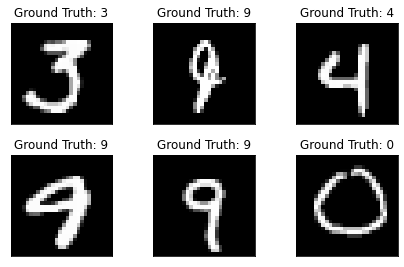

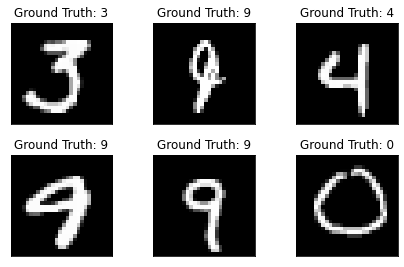

In [43]:
# menampilkan nilai gambar yang di proses
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [44]:
#membuat kelas nn modul
class Net(nn.Module):
  #deklarasi dan inisialisasi variabel
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() 
        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, 10) 
  #melakukan proses relu, pooling, dan dropout
    def forward(self, x): 
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x) #feedback

In [45]:
#memanggil class Net
network = Net() 
#pemanggilan algoritma optimasi
optimizer = optim.SGD(network.parameters(), lr=rate, momentum=momentum)

In [46]:
#membuat list kosong pada trin_losses, train_counter, test_losses, dan menambahkan nilai pada variabel test_counter
train_losses = [] 
train_counter = [] 
test_losses = [] 
test_counter = [i*len(train_loader.dataset) for i in range(n + 1)]

In [47]:
#membuat fungsi untuk melakukan proses training
def train(epoch): 
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [48]:
#membuat fungsi untuk melakukan proses testing
def test(): 
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [49]:
#menampilkan hasil training
test()
for epoch in range(1, n + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302532
Train Epoch: 1 [700/60000 (1%)]	Loss: 2.281216
Train Epoch: 1 [1400/60000 (2%)]	Loss: 2.329659
Train Epoch: 1 [2100/60000 (3%)]	Loss: 2.289010
Train Epoch: 1 [2800/60000 (5%)]	Loss: 2.266396
Train Epoch: 1 [3500/60000 (6%)]	Loss: 2.214166
Train Epoch: 1 [4200/60000 (7%)]	Loss: 2.221586
Train Epoch: 1 [4900/60000 (8%)]	Loss: 2.169383
Train Epoch: 1 [5600/60000 (9%)]	Loss: 2.139859
Train Epoch: 1 [6300/60000 (10%)]	Loss: 2.027886
Train Epoch: 1 [7000/60000 (12%)]	Loss: 1.980233
Train Epoch: 1 [7700/60000 (13%)]	Loss: 1.645896
Train Epoch: 1 [8400/60000 (14%)]	Loss: 1.718428
Train Epoch: 1 [9100/60000 (15%)]	Loss: 1.527201
Train Epoch: 1 [9800/60000 (16%)]	Loss: 1.557458
Train Epoch: 1 [10500/60000 (17%)]	Loss: 1.452929
Train Epoch: 1 [11200/60000 (19%)]	Loss: 1.212002
Train Epoch: 1 [11900/60000 (20%)]	Loss: 1.134971
Train Epoch: 1 [12600/60000 (21%)]	Loss: 1.033615
Train Epoch: 1 [13300/

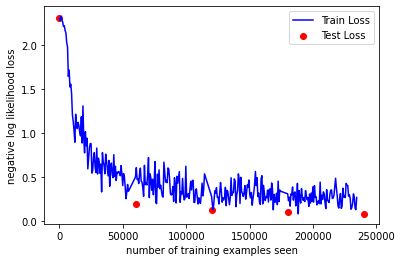

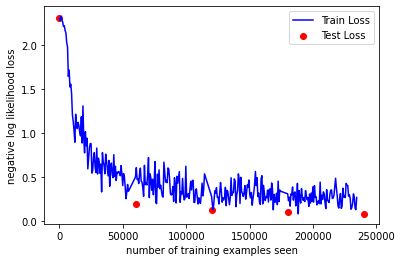

In [50]:
#menampilkan visual plot data hasil training
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig